In [ ]:
!pip install numpy==1.23.1
!pip install pandas==1.4.3
!pip install matplotlib==3.3.2
!pip install seaborn==0.11.0
!pip install joblib==1.1.0
!pip install nltk==3.7
!pip install wordcloud==1.8.2.2
!pip install scikit_learn==1.0.2

# Contents:

I. [Outlier Treatment:](#Outlier-Treatment:)

II. [Feature Engineering:](#Feature-Engineering:)

* [Average price by sub-area:](#Average-price-by-sub-area:)

* [Amenities score:](#Amenities-score:)

* [Average price by Amenities score:](#Average-price-by-Amenities-score:)

III. [Feature Extraction:](#Feature-Extraction:)

* [Wordcloud of the Description:](#Wordcloud-of-the-Description:)

* [POS features:](#POS-features:)

* [Ngram features:](#Ngram-features:)

IV. [Saving the final model ready data:](#Saving-the-final-model-ready-data:)

## Outlier Treatment:

([Contents:](#Contents:))

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time 
import re

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('data/real_estate_selected.csv')
print(df.shape)
df.head()

(199, 17)


,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned
0,pune,maharashtra,india,1.0,bavdhan,shapoorji paloonji,vanaha,shapoorji paloonji comunity located in the sub...,1,1,1,1,1,1,1,492.0,39.0
1,pune,maharashtra,india,2.0,bavdhan,shapoorji paloonji,vanaha,vanaha township located near the lonavala hill...,1,1,1,1,1,1,1,774.0,65.0
2,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha society is suitable for all aged group ...,1,1,1,1,1,1,1,889.0,74.0
3,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha township are offering 3bhk grand prpoer...,1,1,1,1,1,1,1,1018.0,89.0
4,pune,maharashtra,india,2.0,mahalunge,godrej properties,godrej hills retreat,the area is a hub of prestigious schools like ...,1,1,1,1,1,1,1,743.0,74.0


In [8]:
df['Property Area in Sq. Ft. Cleaned'].quantile(0.95)

1662.8999999999999

In [9]:
# Treating outliers in the numeric columns
cols_to_treat = ['Property Area in Sq. Ft. Cleaned','Price in lakhs Cleaned']

print("\nDistribution (raw):")
display(df[cols_to_treat].describe())        

# Outlier treatment
def clip_outliers(df,col):
    q_l = df[col].min()
    q_h = df[col].quantile(0.95)
    df[col] = df[col].clip(lower = q_l, upper = q_h)
    return df

for col in cols_to_treat:
    df = clip_outliers(df,col)
    

print("\nDistribution (after outlier treatment):")
display(df[cols_to_treat].describe())  


Distribution (raw):


,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned
count,199.000000,199.000000
mean,889.984925,95.258291
std,376.812307,101.869843
min,113.000000,13.190000
25%,670.000000,51.500000
50%,796.000000,70.000000
75%,1035.000000,99.435000
max,2447.000000,930.000000



Distribution (after outlier treatment):


,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned
count,199.000000,199.000000
mean,874.226131,84.213065
std,329.153436,44.552319
min,113.000000,13.190000
25%,670.000000,51.500000
50%,796.000000,70.000000
75%,1035.000000,99.435000
max,1662.900000,190.300000


## Feature Engineering:

##### Average price by sub-area:

([Contents:](#Contents:))

,Sub-Area Cleaned,Price in lakhs Cleaned
11,kayani nagar,190.300000
18,lonavala,174.650000
24,nibm,145.575000
17,koregoan,139.500000
10,karvanagar,135.800000
2,baner,132.965000
32,vimannagar,127.500000
0,akurdi,109.666667
16,koregaon park,108.500000
5,bt kawade rd,106.049000


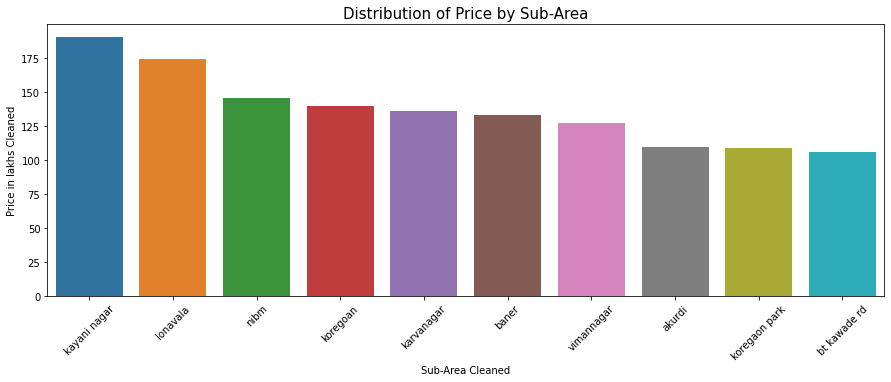

In [10]:
temp = (df.groupby('Sub-Area Cleaned')['Price in lakhs Cleaned'].mean()
            .reset_index().sort_values(by='Price in lakhs Cleaned',ascending=False)[:10])
display(temp)

plt.figure(figsize=(15,5))
sns.barplot(x=temp['Sub-Area Cleaned'],y=temp['Price in lakhs Cleaned'])
plt.title("Distribution of Price by Sub-Area",size=15)
plt.xticks(rotation=45)
plt.show()

In [11]:
# Saving the mapping dict for inference use
sub_area_price_map = df.groupby('Sub-Area Cleaned')['Price in lakhs Cleaned'].mean().to_dict()

import pickle
fileName = 'model/sub_area_price_map.pkl'
with open(fileName,'wb') as f:
    pickle.dump(sub_area_price_map,f)

sub_area_price_map


{'akurdi': 109.66666666666667,
 'balewadi': 83.75,
 'baner': 132.96499999999997,
 'bavdhan': 58.044000000000004,
 'bavdhan budruk': 63.28333333333333,
 'bt kawade rd': 106.049,
 'dhanori': 81.75,
 'hadapsar': 75.6375,
 'handewadi': 45.68818181818182,
 'hinjewadi': 87.52666666666667,
 'karvanagar': 135.8,
 'kayani nagar': 190.29999999999987,
 'keshav nagar': 49.5,
 'kharadi': 66.310625,
 'kirkatwadi sinhagad road': 20.666666666666668,
 'kiwale': 69.665,
 'koregaon park': 108.5,
 'koregoan': 139.5,
 'lonavala': 174.64999999999992,
 'magarpatta': 88.0,
 'mahalunge': 73.55555555555556,
 'manjri': 64.9,
 'mohammadwadi': 45.6,
 'mundhwa': 47.804,
 'nibm': 145.57499999999996,
 'pimpri pune': 54.0,
 'pisoli': 95.99833333333329,
 'ravet': 86.58333333333333,
 'susgaon': 55.24,
 'talegoan': 15.239999999999998,
 'tathawade': 54.0,
 'undri': 45.3,
 'vimannagar': 127.5,
 'wadgaon sheri': 69.12111111111112}

In [12]:
df.groupby('Sub-Area Cleaned')['Price in lakhs Cleaned'].transform('mean')

0       58.044000
1       58.044000
2       58.044000
3       58.044000
4       73.555556
5       73.555556
6       83.750000
7       83.750000
8       86.583333
9       86.583333
10      86.583333
11      86.583333
12      86.583333
13     132.965000
14     132.965000
15      73.555556
16      73.555556
17      73.555556
18      86.583333
19      86.583333
20      86.583333
21      86.583333
22      66.310625
23      66.310625
24      66.310625
25      66.310625
26      66.310625
27      66.310625
28      66.310625
29      66.310625
30      66.310625
31      66.310625
32      66.310625
33      66.310625
34      66.310625
35      83.750000
36      83.750000
37     108.500000
38     108.500000
39      49.500000
40      49.500000
41      20.666667
42      20.666667
43      20.666667
44     109.666667
45     109.666667
46     109.666667
47     109.666667
48     109.666667
49     109.666667
50      54.000000
51      54.000000
52      54.000000
53      54.000000
54      54.000000
55      75

In [13]:
# creating the price by sub-area feature
df['Price by sub-area'] =  df.groupby('Sub-Area Cleaned')['Price in lakhs Cleaned'].transform('mean')
df.head(3)

,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned,Price by sub-area
0,pune,maharashtra,india,1.0,bavdhan,shapoorji paloonji,vanaha,shapoorji paloonji comunity located in the sub...,1,1,1,1,1,1,1,492.0,39.0,58.044
1,pune,maharashtra,india,2.0,bavdhan,shapoorji paloonji,vanaha,vanaha township located near the lonavala hill...,1,1,1,1,1,1,1,774.0,65.0,58.044
2,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha society is suitable for all aged group ...,1,1,1,1,1,1,1,889.0,74.0,58.044


In [14]:
# checking the correlation of the feature
df[['Price by sub-area','Price in lakhs Cleaned']].corr()

,Price by sub-area,Price in lakhs Cleaned
Price by sub-area,1.000000,0.753376
Price in lakhs Cleaned,0.753376,1.000000


##### Amenities score:

([Contents:](#Contents:))

In [15]:
amenities_col = df.columns.tolist()[8:15]
amenities_col

['ClubHouse Cleaned',
 'School / University in Township Cleaned',
 'Hospital in TownShip Cleaned',
 'Mall in TownShip Cleaned',
 'Park / Jogging track Cleaned',
 'Swimming Pool Cleaned',
 'Gym Cleaned']

In [16]:
temp = df[amenities_col]
temp['Amenities score'] = temp.sum(axis=1)
temp['Price'] = df['Price in lakhs Cleaned']
temp.head(3)

,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Amenities score,Price
0,1,1,1,1,1,1,1,7,39.0
1,1,1,1,1,1,1,1,7,65.0
2,1,1,1,1,1,1,1,7,74.0


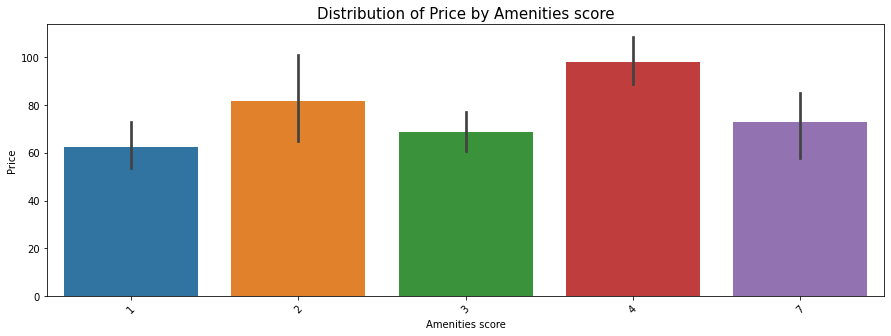

In [17]:
temp2 = (temp.groupby('Amenities score')['Price'].mean()
            .reset_index().sort_values(by='Price',ascending=False)[:10])

plt.figure(figsize=(15,5))
sns.barplot(x=temp['Amenities score'],y=temp['Price'])
plt.title("Distribution of Price by Amenities score",size=15)
plt.xticks(rotation=45)
plt.show()

In [18]:
# Adding the amenitites score feature
df['Amenities score'] = temp['Amenities score']
print(df.shape)
df.head(3)

(199, 19)


,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned,Price by sub-area,Amenities score
0,pune,maharashtra,india,1.0,bavdhan,shapoorji paloonji,vanaha,shapoorji paloonji comunity located in the sub...,1,1,1,1,1,1,1,492.0,39.0,58.044,7
1,pune,maharashtra,india,2.0,bavdhan,shapoorji paloonji,vanaha,vanaha township located near the lonavala hill...,1,1,1,1,1,1,1,774.0,65.0,58.044,7
2,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha society is suitable for all aged group ...,1,1,1,1,1,1,1,889.0,74.0,58.044,7


##### Average price by Amenities score:

([Contents:](#Contents:))

In [19]:
# Saving the mapping dict for inference use
amenities_score_price_map = df.groupby('Amenities score')['Price in lakhs Cleaned'].mean().to_dict()

import pickle
fileName = 'model/amenities_score_price_map.pkl'
with open(fileName,'wb') as f:
    pickle.dump(amenities_score_price_map,f)

amenities_score_price_map

{1: 62.574285714285715,
 2: 81.48103448275862,
 3: 68.51434782608695,
 4: 97.87350515463918,
 7: 72.66666666666667}

In [20]:
# creating the price by amenities score feature
df['Price by Amenities score'] =  df.groupby('Amenities score')['Price in lakhs Cleaned'].transform('mean')
print(df.shape)
df.head(3)

(199, 20)


,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned,Price by sub-area,Amenities score,Price by Amenities score
0,pune,maharashtra,india,1.0,bavdhan,shapoorji paloonji,vanaha,shapoorji paloonji comunity located in the sub...,1,1,1,1,1,1,1,492.0,39.0,58.044,7,72.666667
1,pune,maharashtra,india,2.0,bavdhan,shapoorji paloonji,vanaha,vanaha township located near the lonavala hill...,1,1,1,1,1,1,1,774.0,65.0,58.044,7,72.666667
2,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha society is suitable for all aged group ...,1,1,1,1,1,1,1,889.0,74.0,58.044,7,72.666667


## Feature Extraction:

##### Wordcloud of the Description:

([Contents:](#Contents:))

In [21]:
# !pip install wordcloud

In [22]:
# !pip install nltk

In [23]:
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vithi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [25]:
# Preprocessing the text data

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;!]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS_nlp = set(stopwords.words('english'))

#Custom Stoplist
stoplist = ["i","project","living","home",'apartment',"pune","me","my","myself","we","our","ours","ourselves","you","you're","you've","you'll","you'd","your",
            "yours","yourself","yourselves","he","him","his","himself","she","she's","her","hers","herself","it",
            "it's","its","itself","they","them","their","theirs","themselves","what","which","who","whom","this","that","that'll",
            "these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did",
            "doing","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about",
            "against","between","into","through","during","before","after","above","below","to","from","up","down","in","out",
            "on","off","over","under","again","further","then","once","here","there","when","where","why","all","any",
            "both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too",
            "very","s","t","can","will","just","don","don't","should","should've","now","d","ll","m","o","re","ve","y","ain",
            "aren","couldn","didn","doesn","hadn","hasn",
            "haven","isn","ma","mightn","mustn","needn","shan","shan't",
            "shouldn","wasn","weren","won","rt","rt","qt","for",
            "the","with","in","of","and","its","it","this","i","have","has","would","could","you","a","an",
            "be","am","can","edushopper","will","to","on","is","by","ive","im","your","we","are","at","as","any","ebay","thank","hello","know",
            "need","want","look","hi","sorry","http", "https","body","dear","hello","hi","thanks","sir","tomorrow","sent","send","see","there","welcome","what","well","us"]

STOPWORDS_nlp.update(stoplist)

# Function to preprocess the text
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.replace("\d+"," ") # removing digits
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #removing mentions and urls
    text = text.lower() # lowercase text
    text =  re.sub('[0-9]+', '', text)
    text = REPLACE_BY_SPACE_RE.sub(" ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(" ", text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS_nlp]) # delete stopwors from text
    text = text.strip()
    return text

# Cleaning the "text" column in the data frame using the above defined function
df_text = df["Description Cleaned"].astype(str).apply(text_prepare)
df_text.head()

0    shapoorji paloonji comunity located suburbs ba...
1    vanaha township located near lonavala hill ran...
2    vanaha society suitable aged group people play...
3    vanaha township offering bhk grand prpoerties ...
4    area hub prestigious schools like bishop high ...
Name: Description Cleaned, dtype: object

In [26]:
text = " ".join(sent for sent in df_text)
print("There are {} words in the text.".format(len(text)))

There are 33023 words in the text.


In [27]:
text[:1000]

'shapoorji paloonji comunity located suburbs bavadhan locality situated pleasant environment around bhk property comes swimming pool parking facilty community also comes temples churches near devotional purposes vanaha township located near lonavala hill range offers greenery filled environment friendly community comes bhk furnished affordable price vanaha society suitable aged group people playareafor kids woodland teen park elderly person find serenity community also offers clubhouse gym facilities vanaha township offering bhk grand prpoerties bavdhan area newly launched podium level amenities speak language great design functionality area hub prestigious schools like bishop high school vibgyor intl school boston world school also offers quick access important highways bengaluru solapur mumbai expressway strategically located mahalunge quaint nature loving yet connected suburb godrej hills retreat welcomes experience height high boasts elegant towers stories offering bedroom balewadi

We will use the WordCloud package in python to plot the word cloud. Some of the most common parameters in the function is:

* **max_words:** - Used to set the word limit in the word cloud.
* **height:** - Used to set the height of the plot
* **width:** - Used to set the width of the plot
* **collocations:** - Used to set whether to include collocations (bigrams) of two words
* **stopwords:** - Used to remove words from the plot

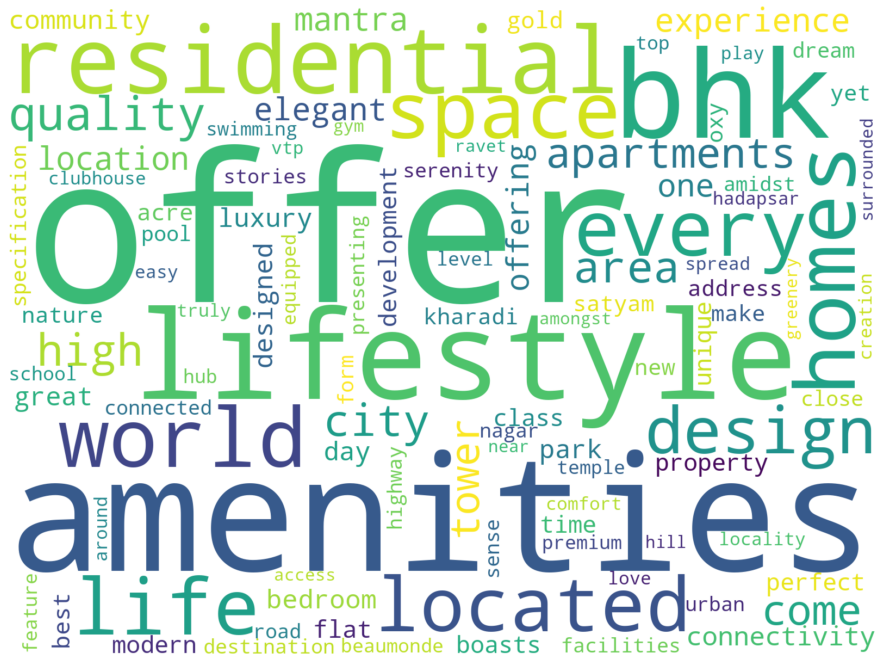

In [28]:
wordcloud = WordCloud(background_color = "white", height=1200, width= 1600, collocations=False , max_words= 100).generate(text)
plt.figure(figsize= (16,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

##### POS features:

([Contents:](#Contents:))

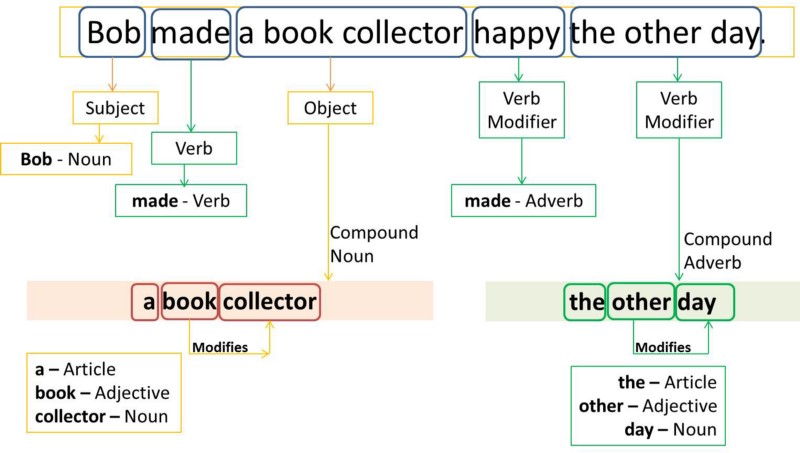

In [29]:
# cleaning the description column
df["Description Cleaned"] =  df["Description Cleaned"].astype(str).apply(text_prepare)

In [30]:
df['Description Cleaned'][:2]

0    shapoorji paloonji comunity located suburbs ba...
1    vanaha township located near lonavala hill ran...
Name: Description Cleaned, dtype: object

In [31]:
# For understanding

# from collections import Counter

# test_text = "my name is john and i live in india"
# tok = nltk.word_tokenize(test_text)
# print(tok)
# tok = [word for word in tok if word not in STOPWORDS_nlp]
# print(tok)
# tags = nltk.pos_tag(nltk.Text(tok))
# print(tags)
# counts = Counter(tag for word,tag in tags)
# counts['NN']

In [32]:
from collections import Counter

def pos_counter(x,pos):
    """
    Returns the count for the given parts of speech tag
    
    NN - Noun
    VB - Verb
    JJ - Adjective
    RB - Adverb
    """
    tokens = nltk.word_tokenize(x.lower())
    tokens = [word for word in tokens if word not in STOPWORDS_nlp]
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tags)
    return counts[pos]

df['Noun_Counts'] = df['Description Cleaned'].apply(lambda x: pos_counter(x,'NN'))
df['Verb_Counts'] = df['Description Cleaned'].apply(lambda x: (pos_counter(x,'VB')+pos_counter(x,'RB')))
df['Adjective_Counts'] = df['Description Cleaned'].apply(lambda x: pos_counter(x,'JJ'))

In [33]:
print(df.shape)
df.head()

(199, 23)


,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned,Price by sub-area,Amenities score,Price by Amenities score,Noun_Counts,Verb_Counts,Adjective_Counts
0,pune,maharashtra,india,1.0,bavdhan,shapoorji paloonji,vanaha,shapoorji paloonji comunity located suburbs ba...,1,1,1,1,1,1,1,492.0,39.0,58.044000,7,72.666667,9,1,3
1,pune,maharashtra,india,2.0,bavdhan,shapoorji paloonji,vanaha,vanaha township located near lonavala hill ran...,1,1,1,1,1,1,1,774.0,65.0,58.044000,7,72.666667,9,1,3
2,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha society suitable aged group people play...,1,1,1,1,1,1,1,889.0,74.0,58.044000,7,72.666667,9,1,3
3,pune,maharashtra,india,3.0,bavdhan,shapoorji paloonji,vanaha,vanaha township offering bhk grand prpoerties ...,1,1,1,1,1,1,1,1018.0,89.0,58.044000,7,72.666667,8,1,3
4,pune,maharashtra,india,2.0,mahalunge,godrej properties,godrej hills retreat,area hub prestigious schools like bishop high ...,1,1,1,1,1,1,1,743.0,74.0,73.555556,7,72.666667,12,1,6


##### Ngram features:

([Contents:](#Contents:))

##### Bag of Words Representation:
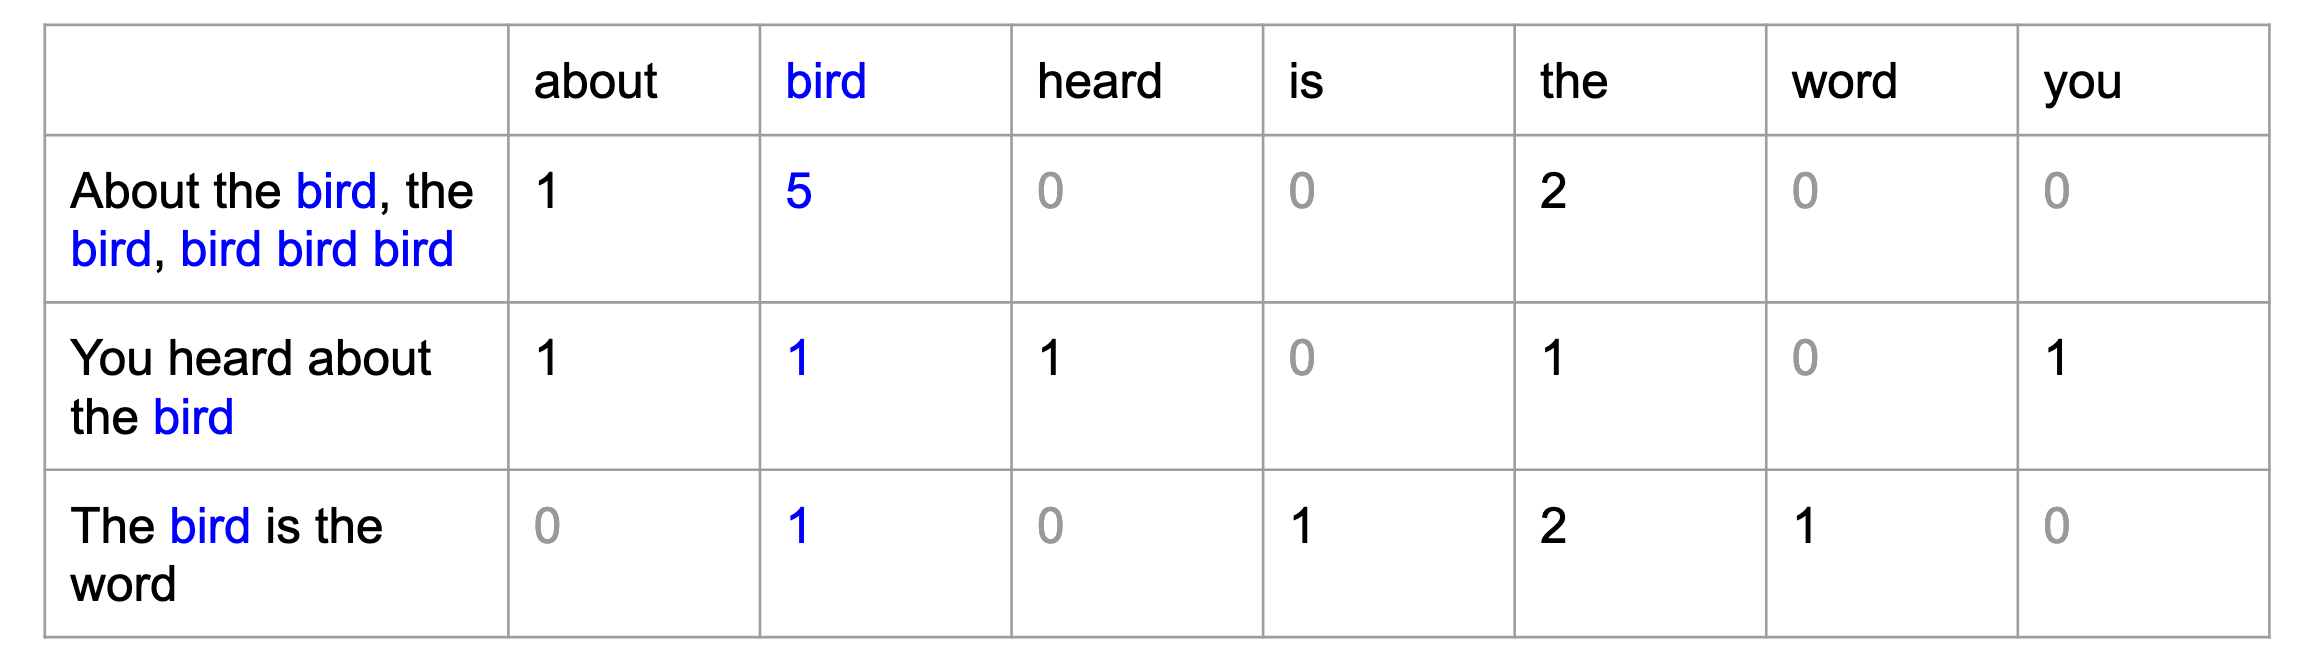

##### Ngram Representation:
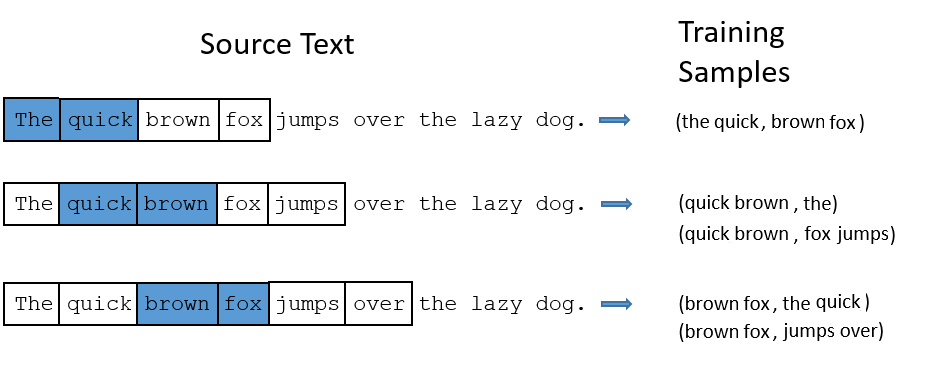

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
cv = CountVectorizer(ngram_range=(2,2),max_features=10)
# cv = CountVectorizer()
cv_object = cv.fit(df['Description Cleaned'])

In [36]:
import pickle
fileName = 'model/count_vectorizer.pkl'
with open(fileName,'wb') as f:
    pickle.dump(cv_object,f)

In [37]:
X = cv_object.transform(df['Description Cleaned'])
print(X.shape)
X.toarray()

(199, 10)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
cv_object.get_feature_names()

['boasts elegant',
 'elegant towers',
 'every day',
 'great community',
 'mantra gold',
 'offering bedroom',
 'quality specification',
 'stories offering',
 'towers stories',
 'world class']

In [39]:
df_ngram = pd.DataFrame(X.toarray(),columns=cv_object.get_feature_names())
print(df_ngram.shape)
df_ngram.head()

(199, 10)


,boasts elegant,elegant towers,every day,great community,mantra gold,offering bedroom,quality specification,stories offering,towers stories,world class
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [40]:
# Adding this to the main dataframe
df_final = pd.concat([df.reset_index(drop=True),df_ngram.reset_index(drop=True)],axis=1)
df_final.shape

(199, 33)

In [41]:
df_final.sample(5)

,City,State,Country,Property Type Cleaned,Sub-Area Cleaned,Company Name Cleaned,TownShip Name/ Society Name Cleaned,Description Cleaned,ClubHouse Cleaned,School / University in Township Cleaned,Hospital in TownShip Cleaned,Mall in TownShip Cleaned,Park / Jogging track Cleaned,Swimming Pool Cleaned,Gym Cleaned,Property Area in Sq. Ft. Cleaned,Price in lakhs Cleaned,Price by sub-area,Amenities score,Price by Amenities score,Noun_Counts,Verb_Counts,Adjective_Counts,boasts elegant,elegant towers,every day,great community,mantra gold,offering bedroom,quality specification,stories offering,towers stories,world class
189,pune,maharashtra,india,2.0,bavdhan,vijaya laxmi infrarealtors,satyam shery,vijaya laxmi infrarealtors aspirational reside...,1,0,0,0,1,0,0,665.0,64.99,58.0440,2,81.481034,5,2,3,0,0,0,0,0,0,0,0,0,0
135,pune,maharashtra,india,2.0,vimannagar,oxy buildcorp,oxy beaumonde,oxy beaumonde acre destination charholi long a...,1,0,0,0,1,1,1,793.0,110.00,127.5000,4,97.873505,8,1,5,0,0,0,0,0,0,0,0,0,1
186,pune,maharashtra,india,1.0,bavdhan,vijaya laxmi infrarealtors,satyam shery,consists beautiful designed bhk apartments exc...,1,0,0,0,1,0,0,392.0,39.49,58.0440,2,81.481034,5,0,4,0,0,0,0,0,0,0,0,0,0
7,pune,maharashtra,india,3.0,balewadi,anp corp,anp universe,boasts elegant towers stories offering bedroom...,1,0,0,0,1,1,1,1174.5,100.00,83.7500,4,97.873505,9,0,1,1,1,0,1,0,1,1,1,1,0
55,pune,maharashtra,india,1.0,hadapsar,proviso group,lesiure town,presenting proviso group thoughtfully designed...,0,0,0,0,1,1,1,460.0,45.50,75.6375,3,68.514348,11,3,4,0,0,0,0,0,0,0,0,0,0


## Saving the final model ready data:

([Contents:](#Contents:))

In [42]:
# Saving the final dataframe with model ready features as a csv file
# df_final.to_csv('data/real_estate_model_ready.csv',index=False)